begin initialize encoder
16
3
1280
bulid model OK!
spleen
01190626V001
Start segmentation


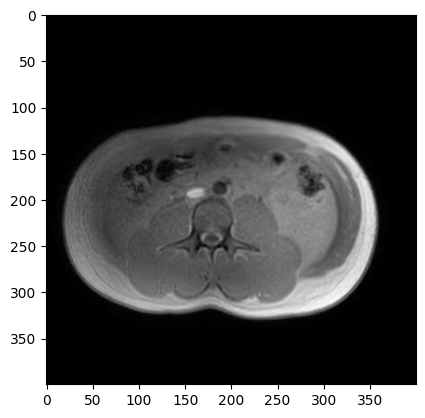

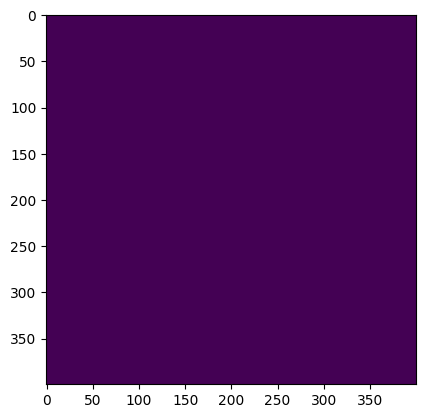

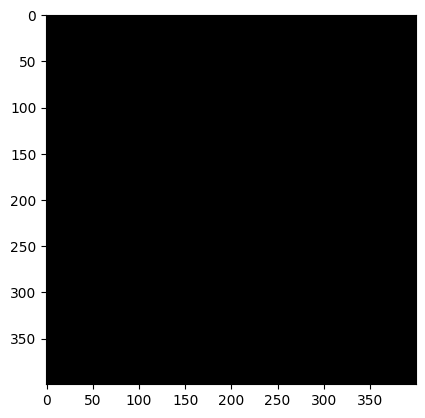

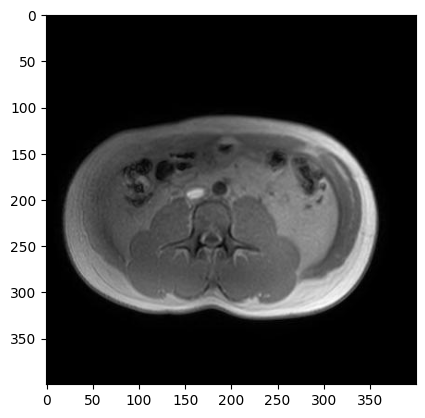

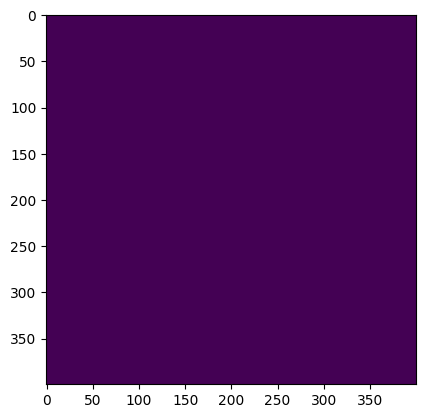

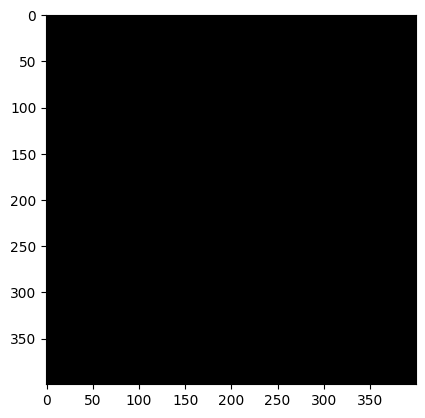

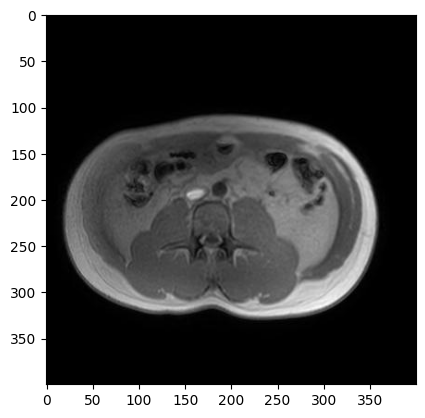

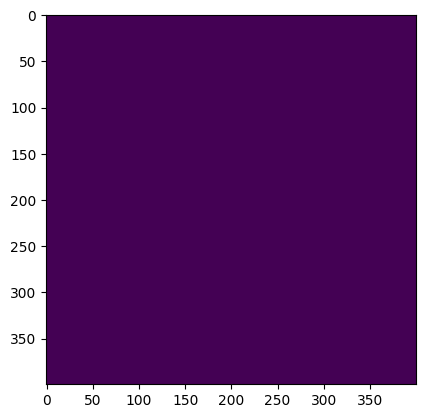

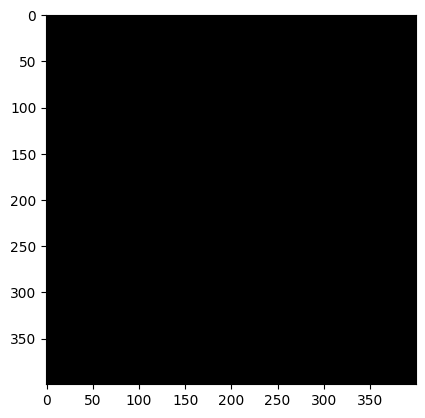

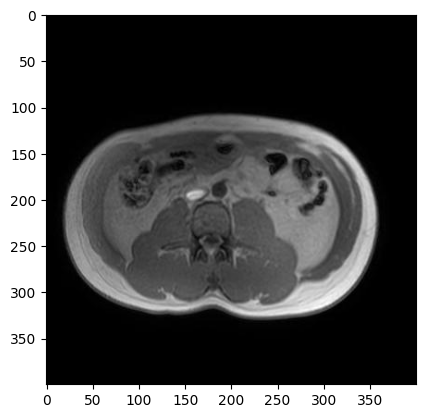

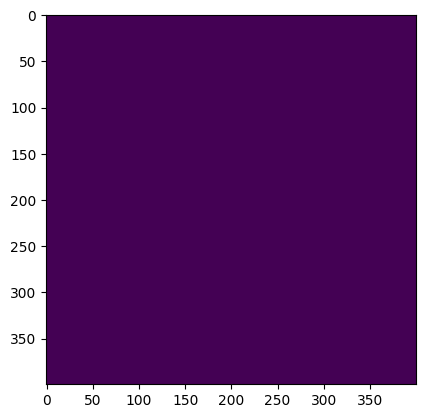

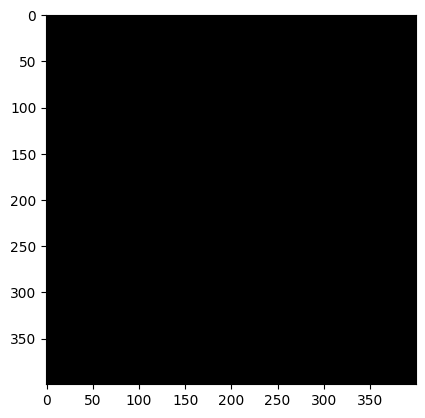

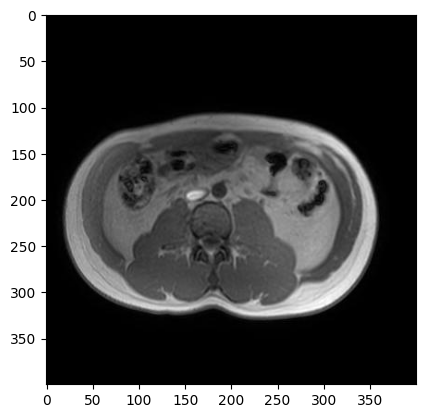

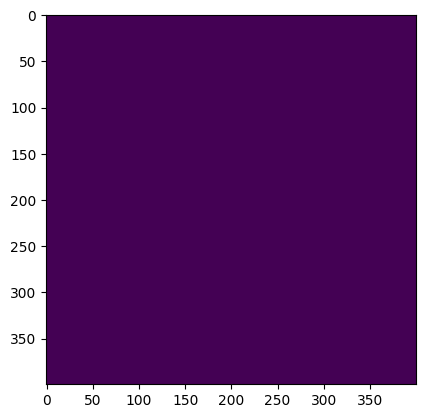

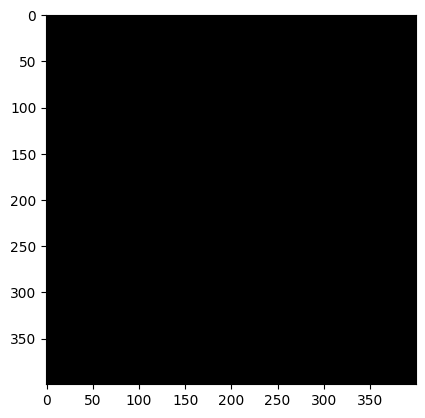

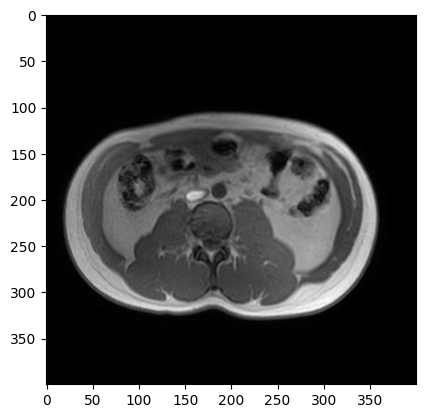

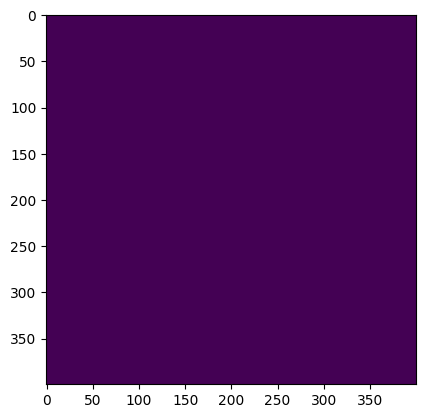

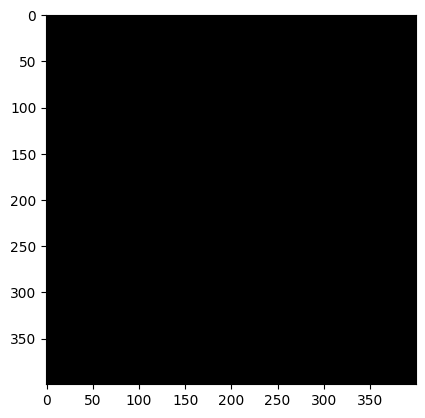

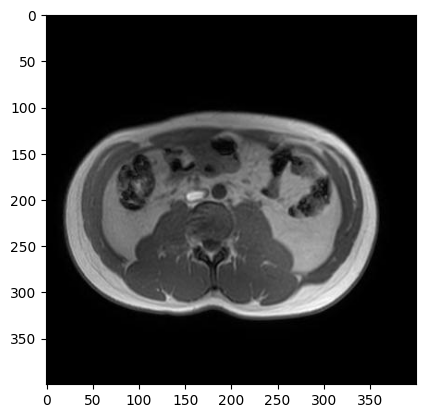

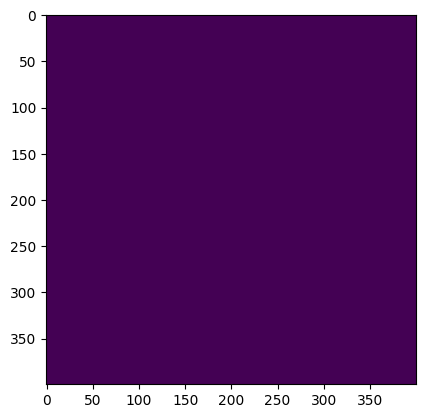

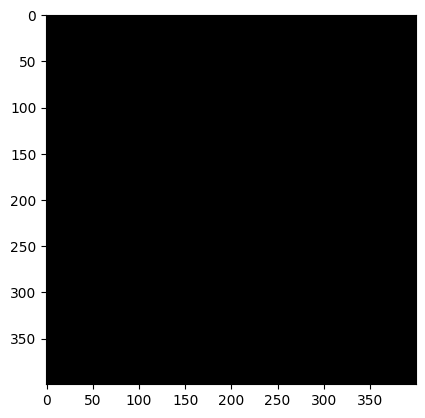


KeyboardInterrupt



In [3]:
import os
import re
import cv2
import numpy as np
from  tqdm import tqdm
import time
import sys
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
from medpy.metric.binary import dc
sys.path.append("../")
sys.path.append("./segment-anything")
from segment_anything import sam_model_registry,SamPredictor


def cal_subject_level_dice(prediction, target, class_num=2):# class_num是你分割的目标的类别个数
    '''
    step1: calculate the dice of each category
    step2: remove the dice of the empty category and background, and then calculate the mean of the remaining dices.
    :param prediction: the automated segmentation result, a numpy array with shape of (h, w, d)
    :param target: the ground truth mask, a numpy array with shape of (h, w, d)
    :param class_num: total number of categories
    :return:
    '''
    eps = 1e-10
    empty_value = -1.0
    dscs = empty_value * np.ones((class_num), dtype=np.float32)
    for i in range(0, class_num):
        if i not in target and i not in prediction:
            continue
        target_per_class = np.where(target == i, 1, 0).astype(np.float32)
        prediction_per_class = np.where(prediction == i, 1, 0).astype(np.float32)

        tp = np.sum(prediction_per_class * target_per_class)
        fp = np.sum(prediction_per_class) - tp
        fn = np.sum(target_per_class) - tp
        dsc = 2 * tp / (2 * tp + fp + fn + eps)
        dscs[i] = dsc
    dscs = np.where(dscs == -1.0, np.nan, dscs)
    subject_level_dice = np.nanmean(dscs[1:])
    return subject_level_dice


def get_str_index(s, c):
    index_list = []
    for i in range(len(s)):
        if c==s[i]:
            index_list.append(i)
    return index_list

def predict_with_bbox():
    organs = ['spleen','liver','kidney', 'pancreas','IVC']
    sam_checkpoint = "./checkpoint/sam_vit_h_4b8939.pth"
    model_type = "vit_h"
    device = "cuda"
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    predictor = SamPredictor(sam)
    
    list_ID_quanji = ['01190626V001']
    
    print('bulid model OK!')
    for organ in organs:
        print(organ)
        for ID in list_ID_quanji:
            print(ID)
            if ID.startswith('0') or ID.startswith('A'):
                    
                image_path=f"./DataSample/"+ID+"/image_abdomen/mDIXON-All_BH_in_phase.nii.gz"
                mask_path=f"./DataSample/"+ID+"/label_"+organ+"/label_"+organ+".nii.gz"
                predict_path=f"./DataSample/"+ID+"/"+organ+"_MedSAM-image"
                if os.path.exists(image_path) and os.path.exists(mask_path):
                    sample_list = [
                                p for p in os.listdir(image_path)
                                if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"] and not p.__contains__('_')
                            ]
                    # if not os.path.exists(predict_path):  
                    if True:
                        print('Start segmentation')
                        if not os.path.exists(predict_path):
                            os.mkdir(predict_path)
                        time0 = time.time()

                        sample_list.sort(key=lambda p: int(os.path.splitext(p)[0]))


                        for index,sample_name in enumerate(sample_list):
                            mask=cv2.imread(os.path.join(mask_path, sample_name),0)
                            image=cv2.imread(os.path.join(image_path, sample_name))
                            image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                            predictor.set_image(image)
                            plt.imshow(image)
                            plt.show()
                            plt.imshow(mask)
                            plt.show()
                            retval, _, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)  

                            retval=retval-1
                            ind=stats[:, 4].argsort()
                            stats = stats[ind][:-1]
                            centroids=centroids[ind][:-1]


                            pre_merge=np.zeros(image.shape,dtype=np.uint8)
                            for i in range(retval):
                                input_bbox = np.array([[stats[i][0], stats[i][1], stats[i][0]+stats[i][2], stats[i][1]+stats[i][3]]])
                                pred, scores, logits = predictor.predict(box=input_bbox, multimask_output=False)
                                h, w = pred.shape[-2:]
                                predict_mask = pred.reshape(h, w,1).astype(np.uint8)*np.array([255, 255, 255], dtype=np.uint8)
                                pre_merge=cv2.add(pre_merge, predict_mask)

                            # cv2.imwrite(os.path.join(predict_path, sample_name), pre_merge)
                            plt.imshow(pre_merge)
                            plt.show()
                        
                                
if   __name__=="__main__":
    predict_with_bbox()